<a href="https://colab.research.google.com/github/HaardhikK/Disease_predict_ml/blob/main/Lsa_and_Lda_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [ ]:

datafile = 'smdisaster.csv'
raw_data = pd.read_csv(datafile, encoding='latin1', parse_dates=[0], infer_datetime_format=True)
raw_data


<ipython-input-50-52e5d6d43520>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_data = pd.read_csv(datafile, encoding='latin1', parse_dates=[0], infer_datetime_format=True)
<ipython-input-50-52e5d6d43520>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_data = pd.read_csv(datafile, encoding='latin1', parse_dates=[0], infer_datetime_format=True)
/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col =

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,778261105,True,golden,100,NaN,Relevant,0.7629,Relevant,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,5675678.0,NaN
10872,778261106,True,golden,90,NaN,Relevant,0.9203,Relevant,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,4234.0,NaN
10873,778261107,True,golden,102,NaN,Relevant,1.0000,Relevant,NaN,NaN,The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d,3242.0,NaN
10874,778261108,True,golden,96,NaN,Relevant,0.8419,Relevant,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,457.0,NaN


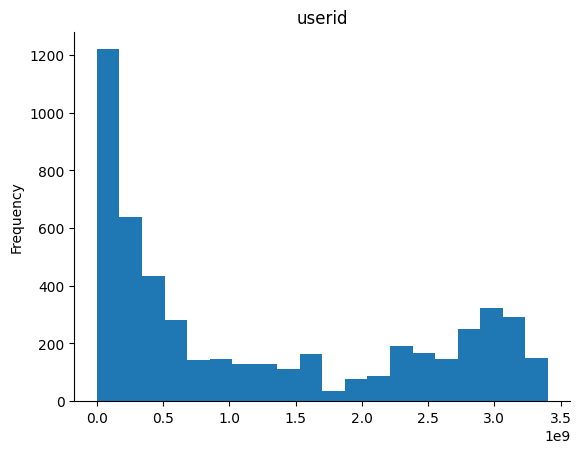

In [ ]:
# @title userid

from matplotlib import pyplot as plt
raw_data['userid'].plot(kind='hist', bins=20, title='userid')
plt.gca().spines[['top', 'right',]].set_visible(False)

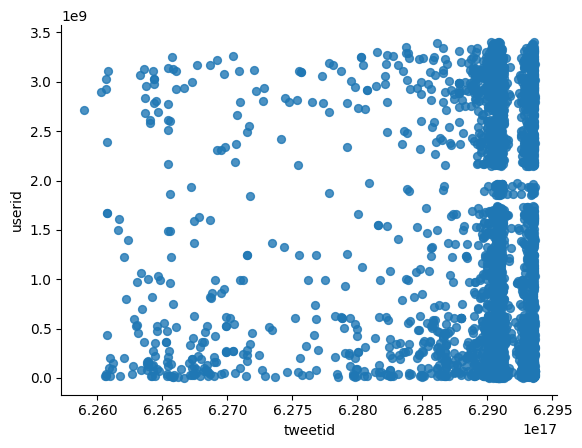

In [ ]:
# @title tweetid vs userid

from matplotlib import pyplot as plt
raw_data.plot(kind='scatter', x='tweetid', y='userid', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
reindexed_data = raw_data['text']
raw_data=reindexed_data
raw_data.head(20)

0                    Just happened a terrible car crash
1     Our Deeds are the Reason of this #earthquake M...
2     Heard about #earthquake is different cities, s...
3     there is a forest fire at spot pond, geese are...
4                Forest fire near La Ronge Sask. Canada
5     All residents asked to 'shelter in place' are ...
6     13,000 people receive #wildfires evacuation or...
7     Just got sent this photo from Ruby #Alaska as ...
8     #RockyFire Update => California Hwy. 20 closed...
9              Apocalypse lighting. #Spokane #wildfires
10    #flood #disaster Heavy rain causes flash flood...
11        Typhoon Soudelor kills 28 in China and Taiwan
12                   We're shaking...It's an earthquake
13    I'm on top of the hill and I can see a fire in...
14    There's an emergency evacuation happening now ...
15    I'm afraid that the tornado is coming to our a...
16          Three people died from the heat wave so far
17    Haha South Tampa is getting flooded hah- W

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
type(raw_data)

pandas.core.series.Series

In [ ]:
raw_data= raw_data.str.lower()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize WordNet lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Lowercasing the text
    text = text.lower()

    # Removing URLs, mentions, hashtags, and other Twitter-specific elements
    text = re.sub(r'https?://\S+|www\.\S+|@[^\s]+|#\S+', '', text)

    # # Tokenization: Splitting the text into individual words or tokens
    # tokens = word_tokenize(text)

    # # Removing stopwords
    # tokens = [word for word in tokens if word not in stop_words]

    # # Lemmatization: reducing words to their base or root form
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # # Joining tokens back into a single string
    # preprocessed_text = ' '.join(tokens)

    return text

# Apply preprocessing to each text entry in raw_data
raw_texts = [preprocess_text(text) for text in raw_data]

# Display the preprocessed texts
raw_texts


['just happened a terrible car crash',
 'our deeds are the reason of this  may allah forgive us all',
 'heard about  is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, i cannot save them all',
 'forest fire near la ronge sask. canada',
 "all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected",
 '13,000 people receive  evacuation orders in california ',
 'just got sent this photo from ruby  as smoke from  pours into a school ',
 ' update => california hwy. 20 closed in both directions due to lake county fire -  ',
 'apocalypse lighting.  ',
 '  heavy rain causes flash flooding of streets in manitou, colorado springs areas',
 'typhoon soudelor kills 28 in china and taiwan',
 "we're shaking...it's an earthquake",
 "i'm on top of the hill and i can see a fire in the woods...",
 "there's an emergency evacuation happening now in the building acros

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0] for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


In [ ]:
import re

# Define the words to be dropped customise
words_to_drop = ['amp', 'û_','like','just','new','know','don']

# Define a function to remove words from text
def remove_words(text):
    # Create a regular expression pattern to match the words to be dropped
    pattern = re.compile(r'\b(?:{})\b'.format('|'.join(words_to_drop)))
    # Use the pattern to replace the matched words with an empty string
    cleaned_text = pattern.sub('', text)
    return cleaned_text

# Remove specified words from each text in raw_texts
cleaned_texts = [remove_words(text) for text in raw_texts]

# Display the cleaned texts
cleaned_texts

# Display the cleaned texts
raw_texts= cleaned_texts
raw_texts

[' happened a terrible car crash',
 'our deeds are the reason of this  may allah forgive us all',
 'heard about  is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, i cannot save them all',
 'forest fire near la ronge sask. canada',
 "all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected",
 '13,000 people receive  evacuation orders in california ',
 ' got sent this photo from ruby  as smoke from  pours into a school ',
 ' update => california hwy. 20 closed in both directions due to lake county fire -  ',
 'apocalypse lighting.  ',
 '  heavy rain causes flash flooding of streets in manitou, colorado springs areas',
 'typhoon soudelor kills 28 in china and taiwan',
 "we're shaking...it's an earthquake",
 "i'm on top of the hill and i can see a fire in the woods...",
 "there's an emergency evacuation happening now in the building across the st

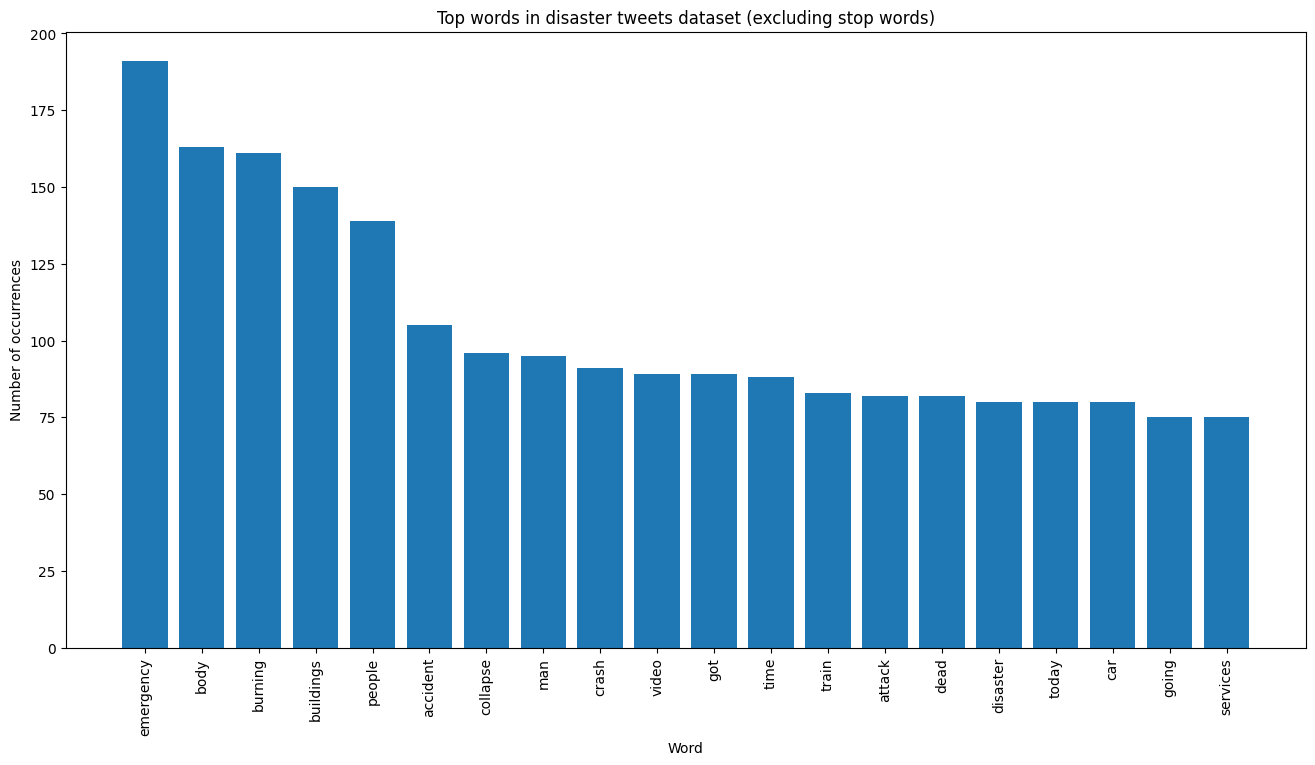

In [ ]:
# Instantiate CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Get top words
words, word_values = get_top_n_words(n_top_words=20,
                                     count_vectorizer=count_vectorizer,
                                     text_data=raw_texts)

# Plotting
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in disaster tweets dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurrences')
plt.show()

In [ ]:
from nltk.corpus import stopwords

# Get the list of English stop words
english_stopwords = set(stopwords.words('english'))

print(english_stopwords)


{'not', 'a', 'for', 'they', 'ourselves', 'while', 'both', 'of', 'm', 'on', 'how', 'weren', 'again', 'should', 'he', 'y', 'yourself', 'wouldn', 'has', 'each', 'against', 'me', 'few', 'needn', 'won', 'd', 'don', 'wasn', 'was', 'from', 'at', 'yours', 'between', "don't", 'hasn', 'does', 'it', 'to', "wouldn't", 'that', "couldn't", 'out', 'up', 'hers', 'am', 'own', 'haven', 'when', 'who', 'i', 'his', "you're", 'yourselves', 'over', "it's", "needn't", 'she', 'themselves', "that'll", 'being', 'is', 'we', 'if', 're', 'an', 'only', 'further', 'will', 'have', 'very', "mustn't", 'doing', 'once', 'there', 'but', 'itself', 'him', 'can', 'our', 'what', 'all', 'or', 'as', "haven't", 'why', 'myself', "you'd", 'do', 'these', 'be', "doesn't", 'shan', 'so', "hasn't", "shouldn't", 'shouldn', 'your', 'where', 'which', 'through', "you've", 'under', 'mightn', "shan't", 'hadn', "she's", "won't", 'above', 'some', 'below', "wasn't", 'ma', 'were', 'just', "hadn't", 'because', 'aren', 'off', 'theirs', 'did', 'no',

In [ ]:
import nltk

# Download the averaged_perceptron_tagger resource
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Tag parts of speech for each word in raw_texts
tagged_raw_texts = [TextBlob(text).pos_tags for text in raw_texts]

# Display the tagged parts of speech
print(tagged_raw_texts)

[[('happened', 'VBD'), ('a', 'DT'), ('terrible', 'JJ'), ('car', 'NN'), ('crash', 'NN')], [('our', 'PRP$'), ('deeds', 'NNS'), ('are', 'VBP'), ('the', 'DT'), ('reason', 'NN'), ('of', 'IN'), ('this', 'DT'), ('may', 'MD'), ('allah', 'VB'), ('forgive', 'JJ'), ('us', 'PRP'), ('all', 'DT')], [('heard', 'NN'), ('about', 'IN'), ('is', 'VBZ'), ('different', 'JJ'), ('cities', 'NNS'), ('stay', 'VB'), ('safe', 'JJ'), ('everyone', 'NN')], [('there', 'EX'), ('is', 'VBZ'), ('a', 'DT'), ('forest', 'JJ'), ('fire', 'NN'), ('at', 'IN'), ('spot', 'NN'), ('pond', 'NN'), ('geese', 'JJ'), ('are', 'VBP'), ('fleeing', 'VBG'), ('across', 'IN'), ('the', 'DT'), ('street', 'NN'), ('i', 'NN'), ('can', 'MD'), ('not', 'RB'), ('save', 'VB'), ('them', 'PRP'), ('all', 'DT')], [('forest', 'JJS'), ('fire', 'NN'), ('near', 'IN'), ('la', 'JJ'), ('ronge', 'NN'), ('sask', 'NN'), ('canada', 'NN')], [('all', 'DT'), ('residents', 'NNS'), ('asked', 'VBD'), ('to', 'TO'), ("'shelter", 'VB'), ('in', 'IN'), ('place', 'NN'), ('are', 'V

In [ ]:
# Create a DataFrame for tagged parts of speech of raw_texts
tagged_raw_texts_df = pd.DataFrame({'tags': tagged_raw_texts})

# Initialize lists to store word counts and POS counts
word_counts = []
pos_counts = {}

# Iterate over each tweet in tagged_raw_texts_df
for tweet_tags in tagged_raw_texts_df['tags']:
    # Count the number of words in the tweet
    word_counts.append(len(tweet_tags))

    # Count the occurrences of each POS tag in the tweet
    for tag in tweet_tags:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1

# Calculate total number of words
total_words = np.sum(word_counts)

# Calculate mean number of words per tweet
mean_word_count = np.mean(word_counts)

# Print results
print('Total number of words:', total_words)
print('Mean number of words per tweet:', mean_word_count)

Total number of words: 69929
Mean number of words per tweet: 13.552131782945736


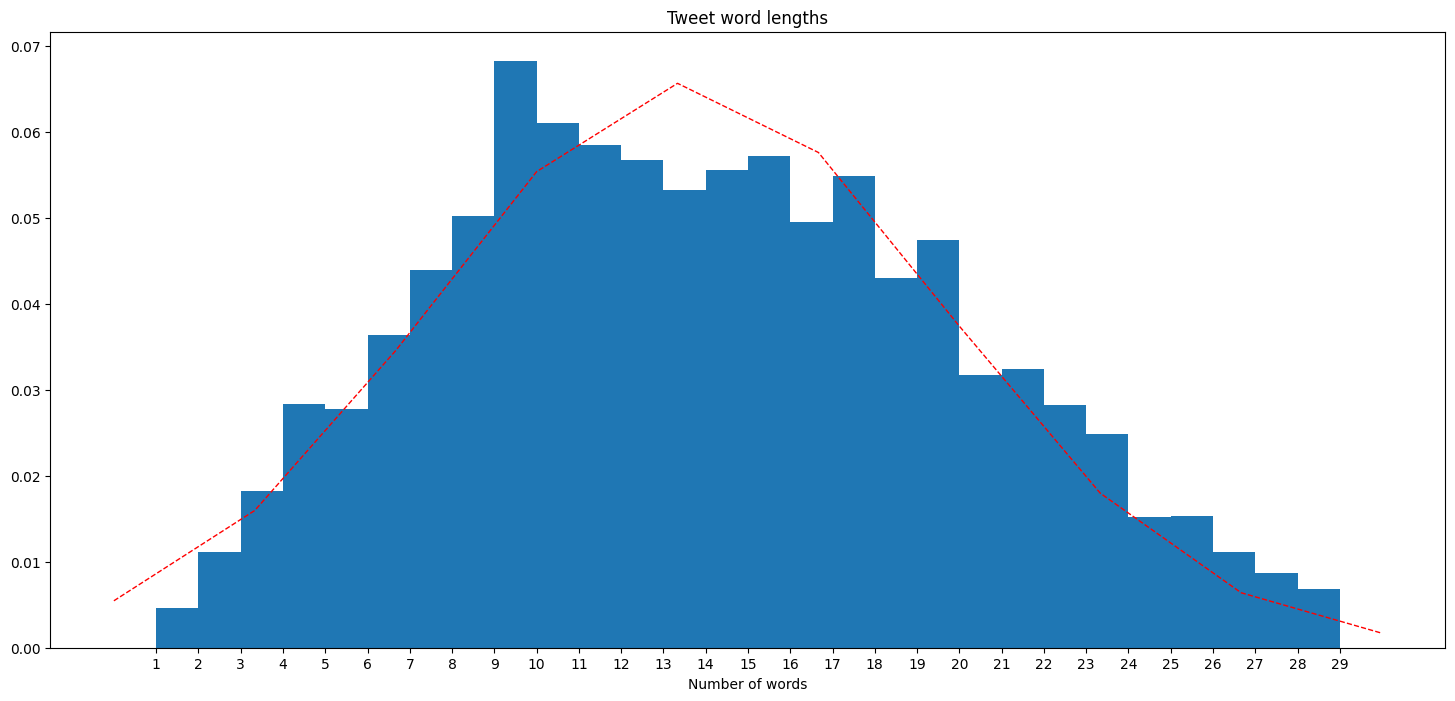

In [ ]:
y = stats.norm.pdf(np.linspace(0,30,10), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,30), density=True);
ax.plot(np.linspace(0,30,10), y, 'r--', linewidth=1);
ax.set_title('Tweet word lengths');
ax.set_xticks(range(1,30));
ax.set_xlabel('Number of words');
plt.show()

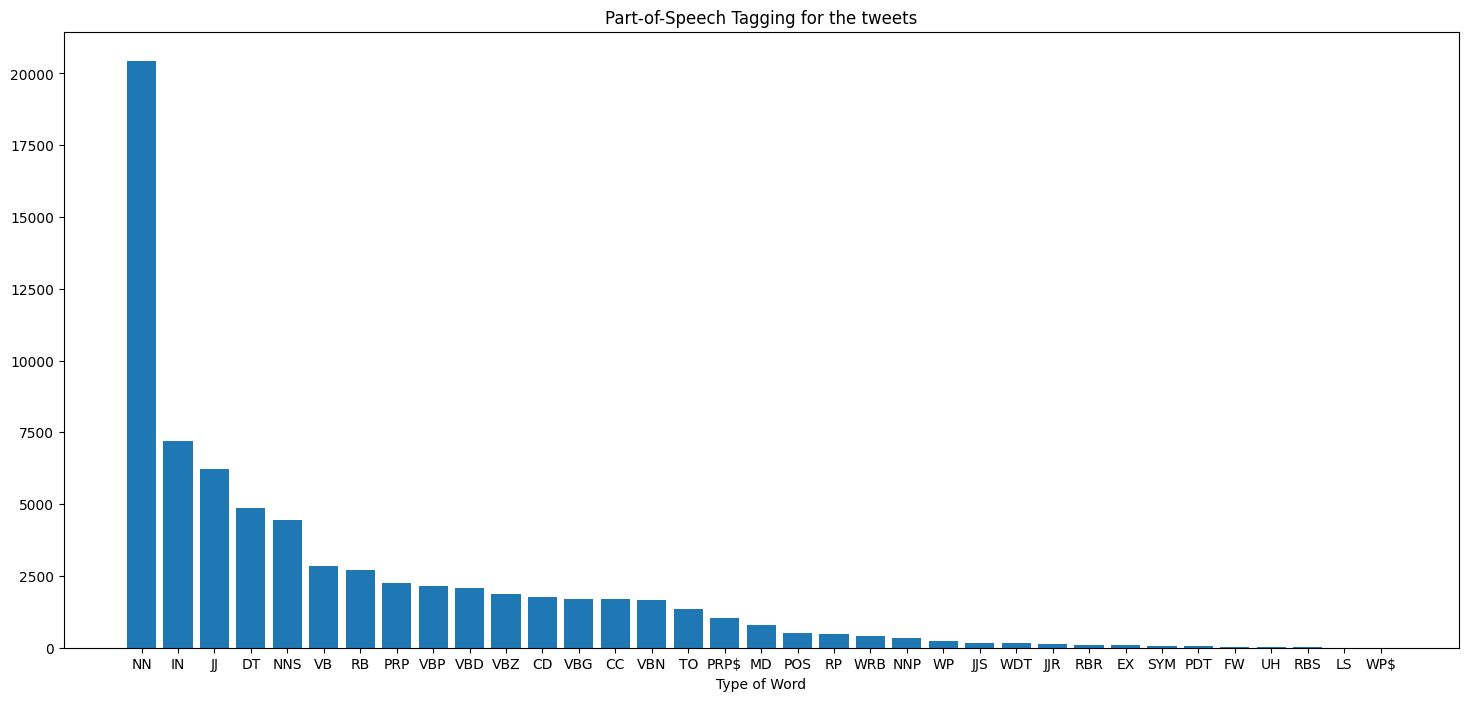

In [ ]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for the tweets');
ax.set_xlabel('Type of Word');

In [ ]:
import pandas as pd

# Convert raw_texts to textsFrame
raw_texts_df = pd.DataFrame({'text': raw_texts})

# Display the textsFrame
print(raw_texts_df.head())


                                                                                               text
0                                                                     happened a terrible car crash
1                                        our deeds are the reason of this  may allah forgive us all
2                                             heard about  is different cities, stay safe everyone.
3  there is a forest fire at spot pond, geese are fleeing across the street, i cannot save them all
4                                                            forest fire near la ronge sask. canada


In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = raw_texts_df['text'].sample(n=10000,replace=True, random_state=0)  # Access text data directly from the DataFrame

print('Tweet before vectorization: {}'.format(small_text_sample.iloc[1]))  # Use .iloc to access the sample by index

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Tweet after vectorization: \n{}'.format(small_document_term_matrix[1]))

Tweet before vectorization: husband's back from edinburgh and crashed out. one young adult's has got a raging temperature the other's gone out and i've not had any tea
Tweet after vectorization: 
  (0, 4252)	1
  (0, 2838)	1
  (0, 2187)	1
  (0, 9395)	1
  (0, 493)	1
  (0, 3760)	1
  (0, 6796)	1
  (0, 8366)	1
  (0, 3739)	1
  (0, 8908)	1
  (0, 8325)	1


In [ ]:
n_topics = 8

### Latent Semantic Analysis


In [ ]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = np.zeros(document_term_matrix.shape[1])
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i].toarray()[0]
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[-n:], 0)
        top_word_indices.append(top_n_word_indices)
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1, document_term_matrix.shape[1]))
            temp_word_vector[:, index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word)
        top_words.append(" ".join(topic_words))
    return top_words

top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i].encode('ascii', 'ignore').decode('utf-8'))



Topic 1:  year 11 old charged boy fatal manslaughter report toddler death
Topic 2:  gt lt collapsed soon aftershock blight ir 320 icemoon ve
Topic 3:  body cross dead bag going bagging love bags man rt
Topic 4:  burning buildings people video train destruction displaced collision destroyed army
Topic 5:  stop national disaster fedex annihilation longer bioterror river wild sensor
Topic 6:  years bomb war atomic got today hiroshima japan devastation 70
Topic 7:  attack life derail crash ur feared trains pray lord floods
Topic 8:  emergency collapse accident debris evacuation make plan bridge time services


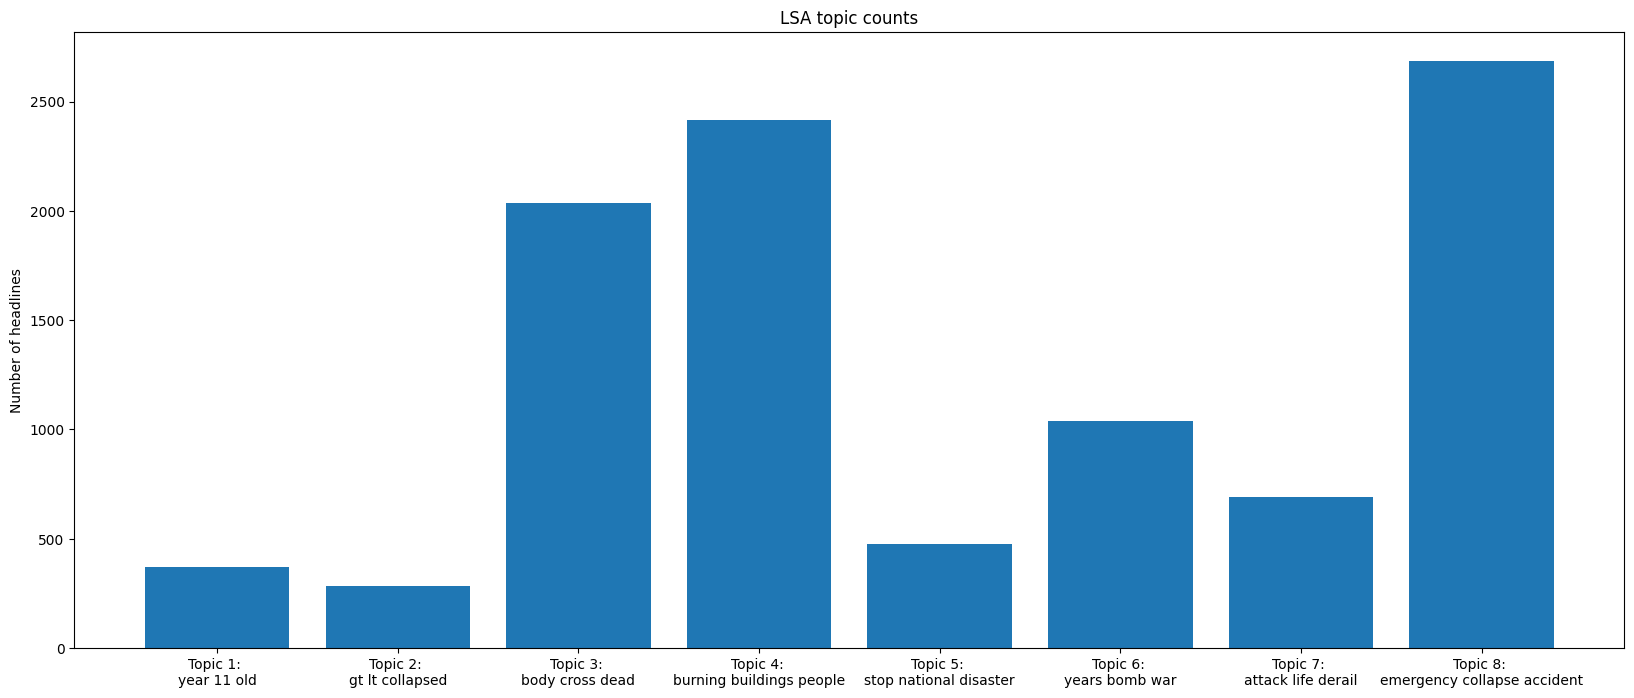

In [ ]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i+1) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels)
ax.set_ylabel('Number of headlines')
ax.set_title('LSA topic counts')
plt.show()


In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.025s...
[t-SNE] Computed neighbors for 10000 samples in 1.789s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.003189
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.495865
[t-SNE] KL divergence after 2000 iterations: 0.663642


In [ ]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])

        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896" ])
colormap = colormap[:n_topics]

#  "#9467bd", "#c5b0d5",
#     "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
#     "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"

In [ ]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), width=700,height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1],
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

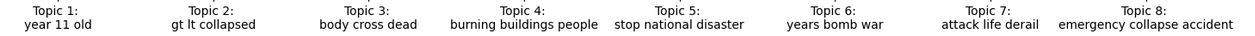

### Latent Dirichilet Allocation


In [ ]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online',
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [ ]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  accident debris dead dust storm mh370 crash reunion car airplane
Topic 2:  collapse people attacked make cliff fall detonate deluged brown apollo
Topic 3:  old man 11 charged year boy disaster longer fedex manslaughter
Topic 4:  body emergency services cross bag bagging bags plan national shoulder
Topic 5:  attack train evacuation derail collapse catastrophe derailment explode ur life
Topic 6:  burning buildings 08 danger annihilated 00 police cyclone 05 16
Topic 7:  gt army famine crush desolation food pick crushed today fan
Topic 8:  atomic hiroshima video years japan 70 death anniversary war bombing


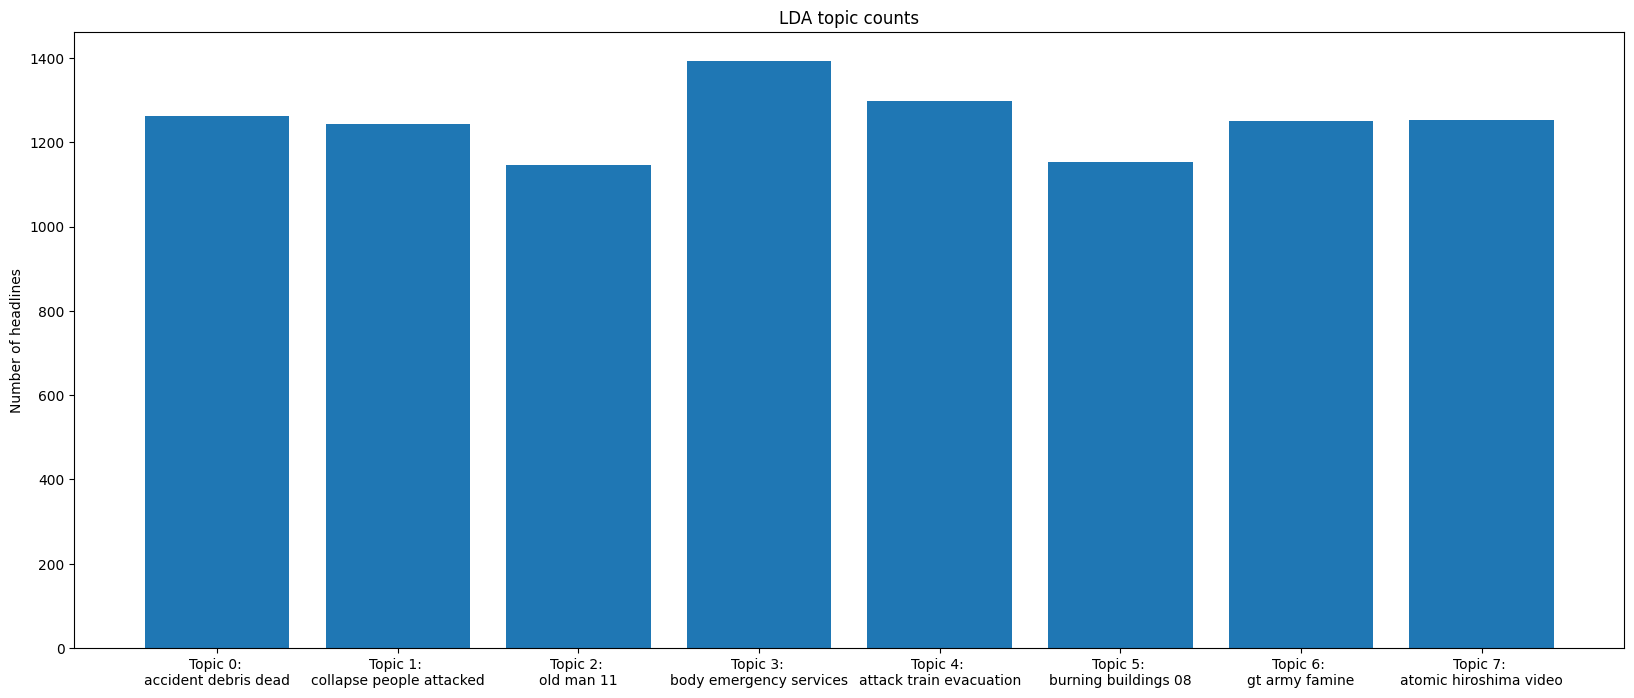

In [ ]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(20,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [ ]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.028s...
[t-SNE] Computed neighbors for 10000 samples in 2.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.720062
[t-SNE] KL divergence after 2000 iterations: 0.671906


In [ ]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1],
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

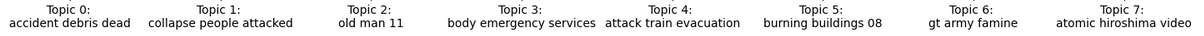

LSA
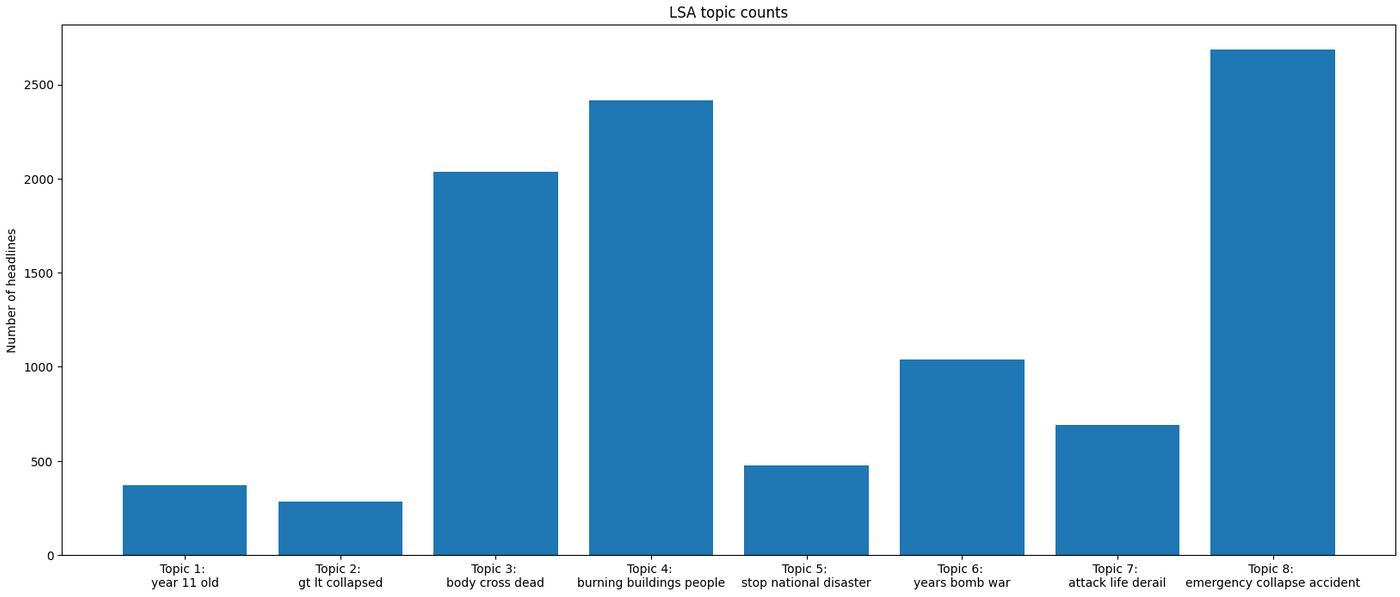


LDA

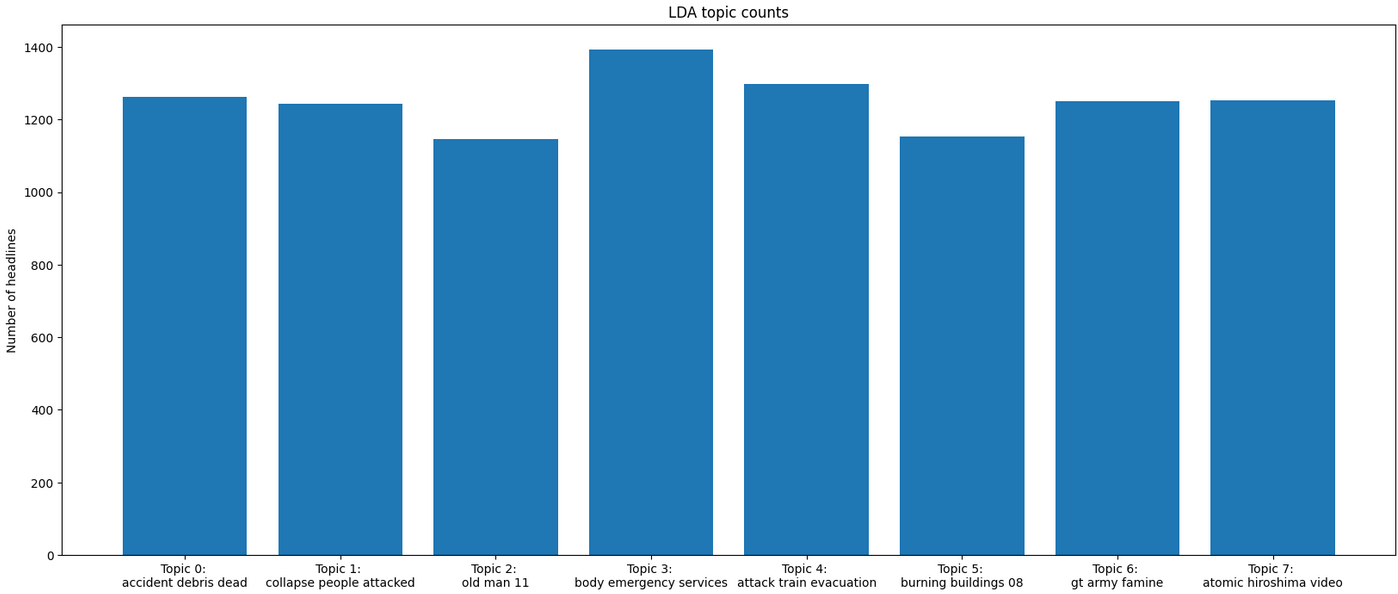

In [ ]:
from bokeh.layouts import gridplot

# Create the first plot for LSA
lsa_plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), width=700, height=700)
lsa_plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1],
                  text=top_3_words_lsa[t], text_color=colormap[t])
    lsa_plot.add_layout(label)

# Create the second plot for LDA
lda_plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=700, height=700)
lda_plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1],
                  text=top_3_words_lda[t], text_color=colormap[t])
    lda_plot.add_layout(label)

# Arrange plots in a grid layout
grid = gridplot([[lsa_plot, lda_plot]])

# Display the grid layout
show(grid)


Testing the models

In [ ]:
def get_sentence_topic(sentence):
    # Preprocess the input sentence
    preprocessed_sentence = preprocess_text(sentence)

    # Vectorize the preprocessed sentence
    sentence_vector = small_count_vectorizer.transform([preprocessed_sentence])

    # Transform the vectorized sentence using the LSA model
    lsa_sentence_topic = lsa_model.transform(sentence_vector)

    # Get the topic number for the sentence
    sentence_topic = np.argmax(lsa_sentence_topic)

    return sentence_topic

# Example usage:

example_sentence = "We should stop natural disaster and take precaution."
topic_number = get_sentence_topic(example_sentence)
print("The example sentence belongs to topic number:", topic_number+1)


The example sentence belongs to topic number: 5


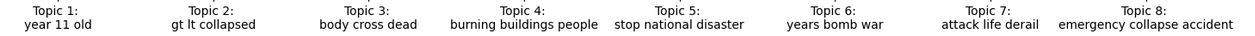

In [ ]:
def get_sentence_topic(sentence):
    # Preprocess the input sentence
    preprocessed_sentence = preprocess_text(sentence)

    # Vectorize the preprocessed sentence
    sentence_vector = small_count_vectorizer.transform([preprocessed_sentence])

    # Transform the vectorized sentence using the LSA model
    lsa_sentence_topic = lsa_model.transform(sentence_vector)

    # Get the topic number for the sentence
    sentence_topic = np.argmax(lsa_sentence_topic)

    return sentence_topic

# Example usage:
example_sentence = "Heavy bombing and wars reported in the coastal region for many years."
topic_number = get_sentence_topic(example_sentence)
print("The example sentence belongs to topic number:", topic_number+1)


The example sentence belongs to topic number: 6


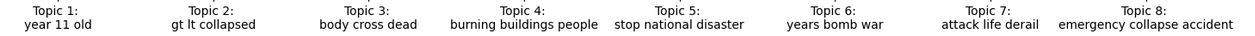

In [ ]:
import nltk
nltk.download('vader_lexicon')
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Example sentence for sentiment analysis
example_sentence = "Heavy bombing and wars reported in the coastal region for many years."

# Perform semantic analysis and sentiment analysis
doc = nlp(example_sentence)
sentiment_scores = [sia.polarity_scores(sent.text)['compound'] for sent in doc.sents]

# Determine the overall sentiment score
overall_sentiment_score = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

# Determine the overall sentiment label
if overall_sentiment_score >= 0.5:
    overall_sentiment_label = "Happy"
elif overall_sentiment_score > 0:
    overall_sentiment_label = "Neutral"
elif overall_sentiment_score <= -0.5:
    overall_sentiment_label = "Sad"
elif overall_sentiment_score < 0:
    overall_sentiment_label = "Angry"
else:
    overall_sentiment_label = "Neutral"  # For cases where sentiment score is exactly 0

# Print the results
print("Detected sentence:", example_sentence)
print("Sentiment scores for the sentence:", sentiment_scores)
# print("Overall sentiment score:", overall_sentiment_score)
print("Overall sentiment label:", overall_sentiment_label)

Detected sentence: Heavy bombing and wars reported in the coastal region for many years.
Sentiment scores for the sentence: [-0.5574]
Overall sentiment label: Sad
